In [169]:
# Libraries used
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import pickle
import seaborn as sb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping

- note: Based off serveral notebooks available on kaggle, this version will be an improved version from the previous

## read data

In [170]:
# check current Directory
import os
os.getcwd()

'C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\digit-recognizer\\predictions'

In [171]:
# set directory to the folder containing the dataset
os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\digit-recognizer\\dataset')
# read the csv as data frame
total_training_set = pd.read_csv('train.csv')
total_test_set = pd.read_csv('test.csv')

## Basic data exploration

In [172]:
# first column is the labels
total_training_set.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [173]:
total_test_set.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
# split predictors from labels 
y_train_full = total_training_set['label']
X_train_full = total_training_set.drop(['label'],axis=1)

In [175]:
print('Training set has {} images with {} pixels.'.format(X_train_full.shape[0],X_train_full.shape[1]))
print('Test set has {} images with {} pixels.'.format(total_test_set.shape[0],total_test_set.shape[1]))

Training set has 42000 images with 784 pixels.
Test set has 28000 images with 784 pixels.


Row 0 is number 1.


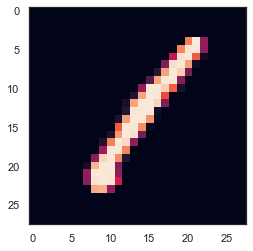

In [176]:
# visualise a row to check validity
row = 0
print('Row {} is number {}.'.format(row,y_train_full[row]))
                                 # reshaped each row to 28 x 28 matrix
plt.imshow(X_train_full.values.reshape((42000,28,28))[row])

Row 34 is number 2.


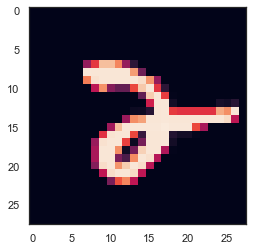

In [177]:
# visualise a row to check validity
row = 34
print('Row {} is number {}.'.format(row,y_train_full[row]))
                            # reshaped each row to 28 x 28 matrix
plt.imshow(X_train_full.values.reshape((42000,28,28))[row])

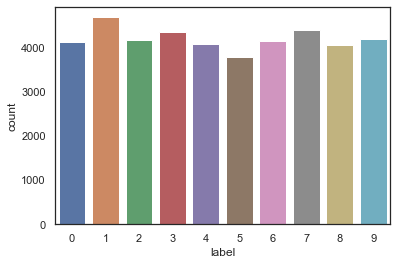

In [178]:
# counts of each number is quite even
sb.set(style='white', context='notebook', palette='deep')
sb.countplot(y_train_full)

# Data Preprocessing

In [179]:
# reshape data to 28 x 28 x 1 dimension, required by the CNN model
                        # .values turns data frame to a matrix
X_train_full= X_train_full.values.reshape((42000,28,28,1))
X_test= total_test_set.values.reshape((28000,28,28,1))

In [180]:
# convert pixels to float values within [0,1] 
X_train_full=X_train_full/255.
X_test=X_test/255.

In [181]:
# split to training and validation sets using train_test_split function
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=(0.25), random_state=42)

In [182]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((31500, 28, 28, 1), (10500, 28, 28, 1), (31500,), (10500,))

In [183]:
# check dimensions
print('Training set Dimensions: \n\tX: {}\n\ty: {}'.format(X_train.shape,y_train.shape))
print('Validation set Dimensions: \n\tX: {}\n\ty: {}'.format(X_valid.shape,y_valid.shape))
print('Test set Dimensions: \n\tX: {}'.format(X_test.shape))

Training set Dimensions: 
	X: (31500, 28, 28, 1)
	y: (31500,)
Validation set Dimensions: 
	X: (10500, 28, 28, 1)
	y: (10500,)
Test set Dimensions: 
	X: (28000, 28, 28, 1)


# Build Convolutional Neural Network

In [184]:
# setting seed to make results reproduceable
np.random.seed(1)
tf.random.set_seed(1)

In [185]:
# create ImageDataGenerator that augments image
train_datagen = ImageDataGenerator( # the generator can choose any value within these ranges to augment the data
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                    # trun off flipping to avoid misclassification of symmetric numbers like 6 and 9
                                  horizontal_flip=False,
                                  vertical_flip=False  )
                                  

# data augmentation NOT required in validation set
test_datagen = ImageDataGenerator()


In [186]:
# generators to feed data into the model
train_generator = train_datagen.flow(X_train, y_train,
                               # image will be fed in this batch sizes
                               batch_size=32)
validation_generator = test_datagen.flow(X_valid, y_valid,
                               # image will be fed in this batch sizes
                               batch_size=32)

In [187]:
# for v2 architecture, there are dropouts at every layer, smaller ANN layer but more convolutional layers
# also padding will be 'same' instead of valid
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [188]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)         

In [189]:
# RMSprop used instead of SGD
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [190]:
# compile model
model.compile(loss='sparse_categorical_crossentropy',
              # sgd refers to stochastic gradient descent
             optimizer=optimizer,
             metrics=['accuracy'])

In [191]:
# This decreases the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [192]:
# model is saved when validation accuracy does not improve after the patience value
checkpoint_cb = ModelCheckpoint('CNN_early_stopping_model_v2.h5',save_best_only = True)
                    # if there are no improvements after 10 epochs training stops
early_stopping_cb = EarlyStopping(patience = 10,
                    restore_best_weights = True)

In [46]:
# training the model 
number_of_epochs = 1000
model_history = model.fit(X_train,y_train,
                          validation_data=(X_valid,y_valid),
                          epochs=number_of_epochs,
                          callbacks= [checkpoint_cb, early_stopping_cb,learning_rate_reduction])

Train on 31500 samples, validate on 10500 samples
Epoch 1/1000
31500/31500 [==============================] - 184s 6ms/step - loss: 0.2207 - accuracy: 0.9295 - val_loss: 0.0719 - val_accuracy: 0.9780
Epoch 2/1000
   32/31500 [..............................] - ETA: 2:16 - loss: 0.0148 - accuracy: 1.0000

C:\Users\tanch\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


31500/31500 [==============================] - 185s 6ms/step - loss: 0.0823 - accuracy: 0.9761 - val_loss: 0.0474 - val_accuracy: 0.9852
Epoch 3/1000
31500/31500 [==============================] - 185s 6ms/step - loss: 0.0673 - accuracy: 0.9805 - val_loss: 0.0512 - val_accuracy: 0.9862
Epoch 4/1000
31500/31500 [==============================] - 185s 6ms/step - loss: 0.0584 - accuracy: 0.9830 - val_loss: 0.0367 - val_accuracy: 0.9887
Epoch 5/1000
31500/31500 [==============================] - 185s 6ms/step - loss: 0.0566 - accuracy: 0.9837 - val_loss: 0.0397 - val_accuracy: 0.9881
Epoch 6/1000
31500/31500 [==============================] - 184s 6ms/step - loss: 0.0522 - accuracy: 0.9855 - val_loss: 0.0585 - val_accuracy: 0.9881
Epoch 7/1000
31500/31500 [==============================] - 184s 6ms/step - loss: 0.0574 - accuracy: 0.9848 - val_loss: 0.0357 - val_accuracy: 0.9905
Epoch 8/1000
31500/31500 [==============================] - 184s 6ms/step - loss: 0.0590 - accuracy: 0.9850 - val

In [49]:
# saving new model history
os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\digit-recognizer')
history_name='v2_trainHistoryDict.pickle'
with open(history_name, 'wb') as file_pi:
    pickle.dump(model_history.history, file_pi)

In [50]:
# load model history of previous model
with open('trainHistoryDict.pickle', 'rb') as file_pi:
    previous_model_history=pickle.load(file_pi, encoding='bytes')

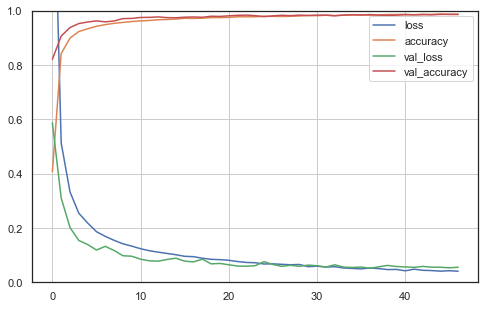

In [51]:
# previous model
pd.DataFrame(previous_model_history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

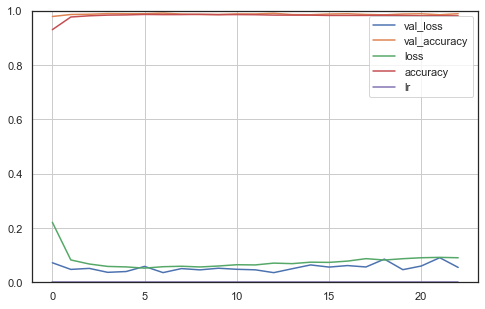

In [47]:
# new model
pd.DataFrame(model_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

- the new model converges reaches best accuracy much faster
- however, the loss seems to worsen over time

# Make Predictions

In [53]:
# the test set
total_test_set.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
# make class predictions
y_pred = model.predict_classes(X_test)
y_pred

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [55]:
# create the output in required format
predictions_dict={'ImageId':range(1,28001),'Label':y_pred}
output_df = pd.DataFrame(predictions_dict).set_index('ImageId')

In [56]:
# set directory and output the predictions
os.chdir('C:\\Users\\tanch\\OneDrive\\Documents\\Kaggle\\digit-recognizer\\predictions')
output_df.to_csv('CNN_predictions.csv')

# results

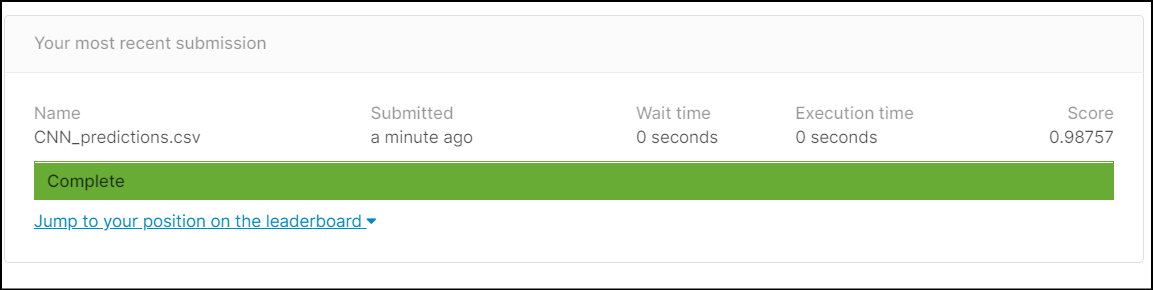

- a 0.005% improvement compared to previous preformance of 0.982%

# Analysing the drawbacks of model

In [57]:
# make predictions on validation set
y_valid_pred = model.predict_classes(X_valid)

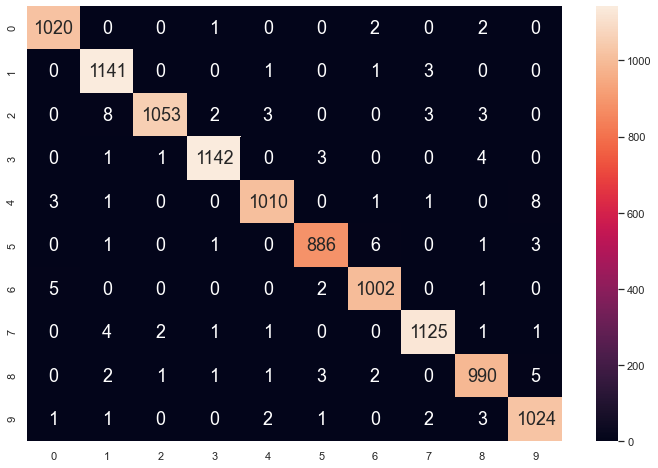

In [61]:
from sklearn.metrics import confusion_matrix
# Plot the Confusion Matrix for validation set
f, axes = plt.subplots(1, 1, figsize=(12, 8))
sb.heatmap(confusion_matrix(y_valid, y_valid_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}).set_xlab

- significant number of misclassifications occur at predicting 4 and 9 

## visualising some misclassifications

In [64]:
# Errors are difference between predicted labels and true labels
errors_boolean = (y_valid_pred - y_valid != 0)

In [66]:
true_values = y_valid[errors_boolean]
false_predictions = y_valid_pred[errors_boolean]

In [110]:
error_df=pd.DataFrame({'true':true_values.values,
                      'false':false_predictions},
                      index=true_values.index)

In [160]:
# extract one example of error for each number
ten_error_indices=[]
for n in range(10):
    for i in error_df.index:
        if error_df.loc[i,'true']==n:
            ten_error_indices.append(i)
            break

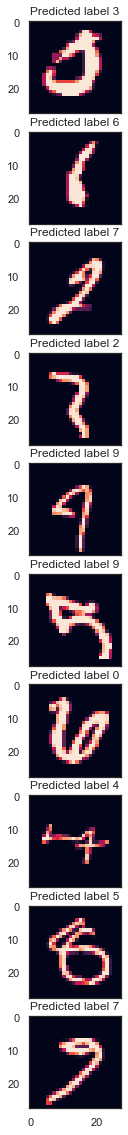

In [167]:
fig, ax = plt.subplots(10,1, figsize=(50, 20),sharex=True,sharey=True)
for i,row in enumerate(ten_error_indices):
    ax[i].imshow((X_train_full[row]).reshape((28,28)))
    ax[i].set_title("Predicted label {}".format(error_df.loc[row,'false']))

## reload model and training history in future

In [ ]:
# # delete model
# del model
# keras.backend.clear_session()

In [ ]:
# to load the model and history again
# model = keras.models.load_model('CNN_early_stopping_model.h5')
# with open('trainHistoryDict.pickle', 'rb') as file_pi:
#     new_hist=pickle.load(file_pi, encoding='bytes')